In [1]:
# Liberally borrowing from various notebooks to get this all in one place

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astroduet.config import Telescope
from astroduet.models import load_model_fluence, load_model_ABmag
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image
from astroduet.utils import suppress_stdout, duet_fluence_to_abmag

# Set up
duet = Telescope()
exposure = 300 * u.s
distance = 100 * u.Mpc
dist_mod = 5. * np.log10(distance.to_value(u.pc)) - 5.

# Load EMGW lightcurves
shock_5e10_time, shock_5e10_fluence1, shock_5e10_fluence2 = load_model_fluence('shock_5e10.dat',distance)
shock_5e10_rate1, shock_5e10_rate2 = duet.fluence_to_rate(shock_5e10_fluence1), duet.fluence_to_rate(shock_5e10_fluence2)
_, shock_5e10_ABmag1, shock_5e10_ABmag2 = load_model_ABmag('shock_5e10.dat',distance)

blukn_04_time, blukn_04_fluence1, blukn_04_fluence2 = load_model_fluence('kilonova_0.04.dat',distance)
blukn_04_rate1, blukn_04_rate2 = duet.fluence_to_rate(blukn_04_fluence1), duet.fluence_to_rate(blukn_04_fluence2)
_, blukn_04_ABmag1, blukn_04_ABmag2 = load_model_ABmag('kilonova_0.04.dat',distance)

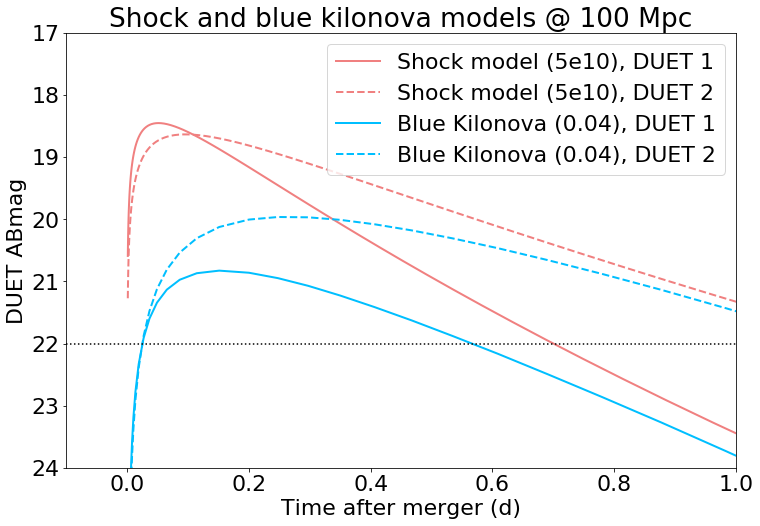

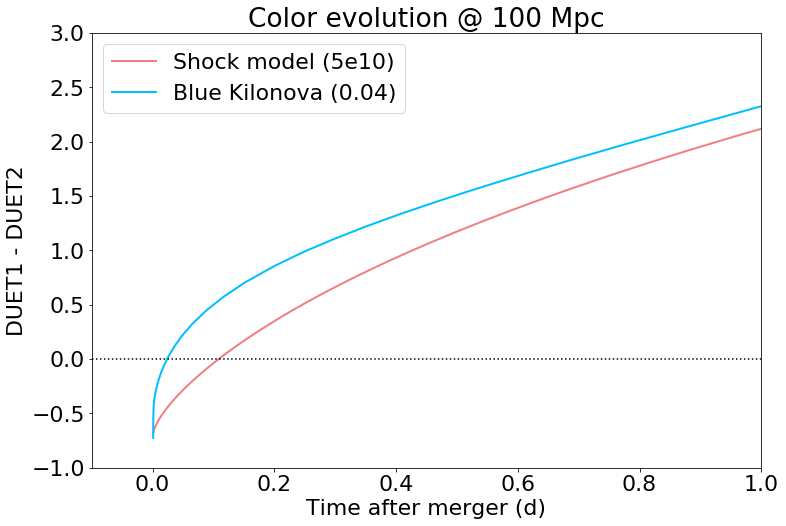

In [2]:
# Plot smooth model inputs
# Plot lightcurve for shock and for blue kilonova, in the two bands, at 100 Mpc
font = {'size': 22}
matplotlib.rc('font', **font)

plt.figure(figsize=(12,8))
plt.plot((shock_5e10_time).to(u.d), shock_5e10_ABmag1, color='lightcoral', linestyle='-', linewidth=2, label='Shock model (5e10), DUET 1')
plt.plot((shock_5e10_time).to(u.d), shock_5e10_ABmag2, color='lightcoral', linestyle='--', linewidth=2, label='Shock model (5e10), DUET 2')

plt.plot((blukn_04_time).to(u.d), blukn_04_ABmag1, color='deepskyblue', linestyle='-', linewidth=2, label='Blue Kilonova (0.04), DUET 1')
plt.plot((blukn_04_time).to(u.d), blukn_04_ABmag2, color='deepskyblue', linestyle='--', linewidth=2, label='Blue Kilonova (0.04), DUET 2')

plt.axhline(y=22,xmin=0,xmax=1,color='black',linestyle=':')
plt.ylim(24,17)
plt.xlim(-0.1,1)
plt.legend()
plt.xlabel('Time after merger (d)')
plt.ylabel(r'DUET ABmag')
plt.title('Shock and blue kilonova models @ 100 Mpc')
plt.show()

plt.figure(figsize=(12,8))
plt.plot((shock_5e10_time).to(u.d), shock_5e10_ABmag1-shock_5e10_ABmag2, color='lightcoral', linestyle='-', linewidth=2, label='Shock model (5e10)')

plt.plot((blukn_04_time).to(u.d), blukn_04_ABmag1-blukn_04_ABmag2, color='deepskyblue', linestyle='-', linewidth=2, label='Blue Kilonova (0.04)')

plt.axhline(y=0,xmin=0,xmax=1,color='black',linestyle=':')
plt.ylim(-1,3)
plt.xlim(-0.1,1)
plt.legend()
plt.xlabel('Time after merger (d)')
plt.ylabel(r'DUET1 - DUET2')
plt.title('Color evolution @ 100 Mpc')
plt.show()


In [3]:
# Get lightcurves through images
shock_lightcurve_init = get_lightcurve("shock_5e10.dat", distance=distance)
shock_lightcurve = lightcurve_through_image(shock_lightcurve_init, exposure=exposure)
shock_lightcurve_rebin = lightcurve_through_image(shock_lightcurve_init, exposure=exposure, final_resolution=2400*u.s)

blukn_lightcurve_init = get_lightcurve("kilonova_0.04.dat", distance=distance)
blukn_lightcurve = lightcurve_through_image(blukn_lightcurve_init, exposure=exposure)
blukn_lightcurve_rebin = lightcurve_through_image(blukn_lightcurve_init, exposure=exposure, final_resolution=2400*u.s)


In [4]:
# And with a spiral galaxy in place
shock_lightcurve_gal = lightcurve_through_image(shock_lightcurve_init, exposure=exposure, gal_type='spiral')
blukn_lightcurve_gal = lightcurve_through_image(blukn_lightcurve_init, exposure=exposure, gal_type='spiral')

shock_lightcurve_gal_rebin = lightcurve_through_image(shock_lightcurve_init, exposure=exposure, gal_type='spiral', 
                                                      final_resolution=2400*u.s)
blukn_lightcurve_gal_rebin = lightcurve_through_image(blukn_lightcurve_init, exposure=exposure, gal_type='spiral', 
                                                      final_resolution=2400*u.s)

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


In [5]:
# Note: surface brightness is independent of distance, galaxy angular size is not
def get_plottables(lc):
    good1 = (lc['fluence_D1_fit'] > 0) & (lc['fluence_D1_fiterr'] < lc['fluence_D1_fit'])
    good2 = (lc['fluence_D2_fit'] > 0) & (lc['fluence_D2_fiterr'] < lc['fluence_D2_fit'])
    good = good1 & good2
    
    rate_meas1, rate_meas2 = duet.fluence_to_rate(lc['fluence_D1_fit']), duet.fluence_to_rate(lc['fluence_D2_fit'])
    rate_meas_err1, rate_meas_err2 = duet.fluence_to_rate(lc['fluence_D1_fiterr']), duet.fluence_to_rate(lc['fluence_D2_fiterr'])

    mag_meas1, mag_meas2 = duet_fluence_to_abmag(lc['fluence_D1_fit'], band=duet.bandpass1), duet_fluence_to_abmag(lc['fluence_D2_fit'], band=duet.bandpass2)
    color = mag_meas1 - mag_meas2
    
    return rate_meas1, rate_meas2, rate_meas_err1, rate_meas_err2, mag_meas1, mag_meas2, color, good
    
# Measured stuff
shock_rate_meas1, shock_rate_meas2, shock_rate_meas_err1, shock_rate_meas_err2, shock_mag_meas1, shock_mag_meas2, shock_color, sgood = get_plottables(shock_lightcurve)
blukn_rate_meas1, blukn_rate_meas2, blukn_rate_meas_err1, blukn_rate_meas_err2, blukn_mag_meas1, blukn_mag_meas2, blukn_color, bgood = get_plottables(blukn_lightcurve)

shock_rate_rebin_meas1, shock_rate_rebin_meas2, shock_rate_rebin_meas_err1, shock_rate_rebin_meas_err2, shock_mag_rebin_meas1, shock_mag_rebin_meas2, shock_rebin_color, srgood = get_plottables(shock_lightcurve_rebin)
blukn_rate_rebin_meas1, blukn_rate_rebin_meas2, blukn_rate_rebin_meas_err1, blukn_rate_rebin_meas_err2, blukn_mag_rebin_meas1, blukn_mag_rebin_meas2, blukn_rebin_color, brgood = get_plottables(blukn_lightcurve_rebin)

shock_rate_gal_meas1, shock_rate_gal_meas2, shock_rate_gal_meas_err1, shock_rate_gal_meas_err2, shock_mag_gal_meas1, shock_mag_gal_meas2, shock_color_gal, sggood = get_plottables(shock_lightcurve_gal)
blukn_rate_gal_meas1, blukn_rate_gal_meas2, blukn_rate_gal_meas_err1, blukn_rate_gal_meas_err2, blukn_mag_gal_meas1, blukn_mag_gal_meas2, blukn_color_gal, bggood = get_plottables(blukn_lightcurve_gal)

shock_rate_gal_rebin_meas1, shock_rate_gal_rebin_meas2, shock_rate_gal_rebin_meas_err1, shock_rate_gal_rebin_meas_err2, shock_mag_gal_rebin_meas1, shock_mag_gal_rebin_meas2, shock_gal_rebin_color, sgrgood = get_plottables(shock_lightcurve_gal_rebin)
blukn_rate_gal_rebin_meas1, blukn_rate_gal_rebin_meas2, blukn_rate_gal_rebin_meas_err1, blukn_rate_gal_rebin_meas_err2, blukn_mag_gal_rebin_meas1, blukn_mag_gal_rebin_meas2, blukn_gal_rebin_color, bgrgood = get_plottables(blukn_lightcurve_gal_rebin)


/anaconda3/lib/python3.6/site-packages/astropy/units/function/logarithmic.py:43: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/anaconda3/lib/python3.6/site-packages/astropy/units/function/logarithmic.py:43: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


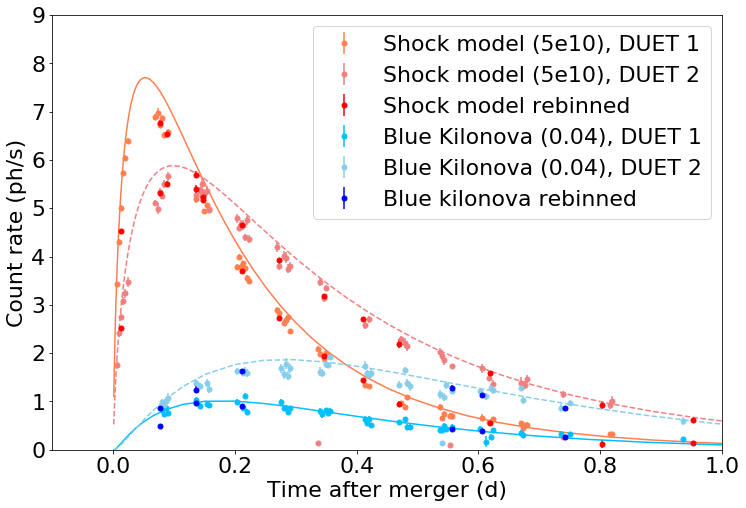

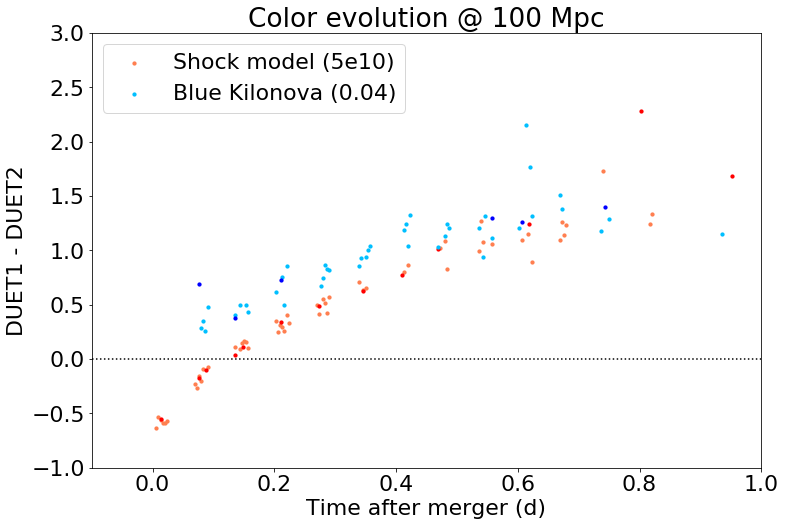

In [7]:
font = {'size': 22}
matplotlib.rc('font', **font)

plt.figure(figsize=(12, 8))

plt.plot((shock_5e10_time).to(u.d), shock_5e10_rate1, color='coral', linestyle='-')
plt.plot((shock_5e10_time).to(u.d), shock_5e10_rate2, color='lightcoral', linestyle='--')
plt.plot((blukn_04_time).to(u.d), blukn_04_rate1, color='deepskyblue', linestyle='-')
plt.plot((blukn_04_time).to(u.d), blukn_04_rate2, color='skyblue', linestyle='--')

plt.errorbar(shock_lightcurve['time'].to(u.d).value[sgood], shock_rate_meas1.value[sgood], fmt='o', 
             markersize=5, yerr=shock_rate_meas_err1.value[sgood], color='coral', label='Shock model (5e10), DUET 1')
plt.errorbar(shock_lightcurve['time'].to(u.d).value[sgood], shock_rate_meas2.value[sgood], fmt='o', 
             markersize=5, yerr=shock_rate_meas_err2.value[sgood], color='lightcoral', label='Shock model (5e10), DUET 2')

plt.errorbar(shock_lightcurve_rebin['time'].to(u.d).value[srgood], shock_rate_rebin_meas1.value[srgood], fmt='o', 
             markersize=5, yerr=shock_rate_rebin_meas_err1.value[srgood], color='red', label='Shock model rebinned')
plt.errorbar(shock_lightcurve_rebin['time'].to(u.d).value[srgood], shock_rate_rebin_meas2.value[srgood], fmt='o', 
             markersize=5, yerr=shock_rate_rebin_meas_err2.value[srgood], color='red')

plt.errorbar(blukn_lightcurve['time'].to(u.d).value[bgood], blukn_rate_meas1.value[bgood], fmt='o', 
             markersize=5, yerr=blukn_rate_meas_err1.value[bgood], color='deepskyblue', label='Blue Kilonova (0.04), DUET 1')
plt.errorbar(blukn_lightcurve['time'].to(u.d).value[bgood], blukn_rate_meas2.value[bgood], fmt='o', 
             markersize=5, yerr=blukn_rate_meas_err2.value[bgood], color='skyblue', label='Blue Kilonova (0.04), DUET 2')

plt.errorbar(blukn_lightcurve_rebin['time'].to(u.d).value[brgood], blukn_rate_rebin_meas1.value[brgood], fmt='o', 
             markersize=5, yerr=blukn_rate_rebin_meas_err1.value[brgood], color='blue', label='Blue kilonova rebinned')
plt.errorbar(blukn_lightcurve_rebin['time'].to(u.d).value[brgood], blukn_rate_rebin_meas2.value[brgood], fmt='o', 
             markersize=5, yerr=blukn_rate_rebin_meas_err2.value[brgood], color='blue')

plt.legend()
plt.ylabel("Count rate (ph/s)")
plt.xlabel("Time after merger (d)")
plt.ylim(0,9)
plt.xlim(-0.1,1)
plt.show()
'''
plt.figure(figsize=(12, 8))
plt.scatter(shock_lightcurve['time'].to(u.d).value, shock_lightcurve['snr_D1'], s=5, color='coral', label='Shock model (2.5e10)')
plt.scatter(shock_lightcurve['time'].to(u.d).value, shock_lightcurve['snr_D2'], s=5, color='lightcoral', label='_Shock model (2.5e10)')

plt.scatter(blukn_lightcurve['time'].to(u.d).value, blukn_lightcurve['snr_D1'], s=5, color='deepskyblue', label='Blue Kilonova (0.01)')
plt.scatter(blukn_lightcurve['time'].to(u.d).value, blukn_lightcurve['snr_D2'], s=5, color='skyblue', label='_Blue Kilonova (0.01)')
plt.ylabel("S/N")
plt.xlabel("Time after merger (d)")
plt.xlim(-0.1,1)
plt.legend()
plt.show()
'''
plt.figure(figsize=(12,8))
plt.scatter(shock_lightcurve['time'].to(u.d).value[sgood], shock_color.value[sgood], s=5,
            color='coral', linewidth=2, label='Shock model (5e10)')

plt.scatter(shock_lightcurve_rebin['time'].to(u.d).value[srgood], shock_rebin_color.value[srgood], s=5,
            color='red', linewidth=2, label='_Shock model (5e10)')


plt.scatter(blukn_lightcurve['time'].to(u.d).value[bgood], blukn_color.value[bgood], s=5,
            color='deepskyblue', linewidth=2, label='Blue Kilonova (0.04)')

plt.scatter(blukn_lightcurve_rebin['time'].to(u.d).value[brgood], blukn_rebin_color.value[brgood], s=5,
            color='blue', linewidth=2, label='_Blue Kilonova (0.04)')

plt.axhline(y=0,xmin=0,xmax=1,color='black',linestyle=':')
plt.ylim(-1,3)
plt.xlim(-0.1,1)
plt.legend()
plt.xlabel('Time after merger (d)')
plt.ylabel('DUET1 - DUET2')
plt.title('Color evolution @ 100 Mpc')
plt.show()



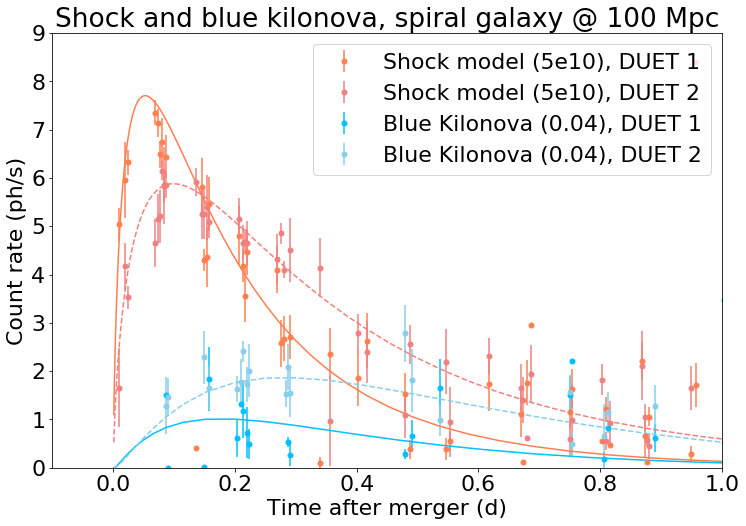

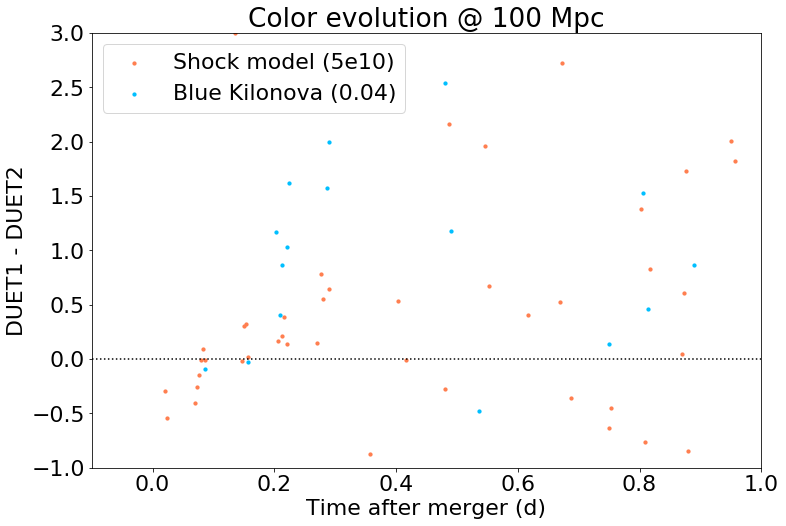

In [10]:
# This time with added galaxy
plt.figure(figsize=(12, 8))

plt.plot((shock_5e10_time).to(u.d), shock_5e10_rate1, color='coral', linestyle='-')
plt.plot((shock_5e10_time).to(u.d), shock_5e10_rate2, color='lightcoral', linestyle='--')
plt.plot((blukn_04_time).to(u.d), blukn_04_rate1, color='deepskyblue', linestyle='-')
plt.plot((blukn_04_time).to(u.d), blukn_04_rate2, color='skyblue', linestyle='--')

plt.errorbar(shock_lightcurve_gal['time'].to(u.d).value[sggood], shock_rate_gal_meas1.value[sggood], fmt='o', 
             markersize=5, yerr=shock_rate_gal_meas_err1.value[sggood], color='coral', label='Shock model (5e10), DUET 1')
plt.errorbar(shock_lightcurve_gal['time'].to(u.d).value[sggood], shock_rate_gal_meas2.value[sggood], fmt='o', 
             markersize=5, yerr=shock_rate_gal_meas_err2.value[sggood], color='lightcoral', label='Shock model (5e10), DUET 2')

plt.errorbar(blukn_lightcurve_gal['time'].to(u.d).value[bggood], blukn_rate_gal_meas1.value[bggood], fmt='o', 
             markersize=5, yerr=blukn_rate_gal_meas_err1.value[bggood], color='deepskyblue', label='Blue Kilonova (0.04), DUET 1')
plt.errorbar(blukn_lightcurve_gal['time'].to(u.d).value[bggood], blukn_rate_gal_meas2.value[bggood], fmt='o', 
             markersize=5, yerr=blukn_rate_gal_meas_err2.value[bggood], color='skyblue', label='Blue Kilonova (0.04), DUET 2')

#plt.errorbar(shock_lightcurve_gal_rebin['time'].to(u.d).value[sgrgood], shock_rate_gal_rebin_meas1.value[sgrgood], fmt='o', 
#             markersize=5, yerr=shock_rate_gal_rebin_meas_err1.value[sgrgood], color='darkred', label='_Shock model (5e10)')
#plt.errorbar(shock_lightcurve_gal_rebin['time'].to(u.d).value[sgrgood], shock_rate_gal_rebin_meas2.value[sgrgood], fmt='o', 
#             markersize=5, yerr=shock_rate_gal_rebin_meas_err2.value[sgrgood], color='red', label='_Shock model (5e10)')

#plt.errorbar(blukn_lightcurve_gal_rebin['time'].to(u.d).value[bgrgood], blukn_rate_gal_rebin_meas1.value[bgrgood], fmt='o', 
#             markersize=5, yerr=blukn_rate_gal_rebin_meas_err1.value[bgrgood], color='darkblue', label='_Blue Kilonova (0.04)')
#plt.errorbar(blukn_lightcurve_gal_rebin['time'].to(u.d).value[bgrgood], blukn_rate_gal_rebin_meas2.value[bgrgood], fmt='o', 
#             markersize=5, yerr=blukn_rate_gal_rebin_meas_err2.value[bgrgood], color='blue', label='_Blue Kilonova (0.04)')

plt.legend()
plt.title('Shock and blue kilonova, spiral galaxy @ 100 Mpc')
plt.ylabel("Count rate (ph/s)")
plt.xlabel("Time after merger (d)")
plt.ylim(0,9)
plt.xlim(-0.1,1)
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(shock_lightcurve_gal['time'].to(u.d).value[sggood], shock_color_gal.value[sggood], s=5,
            color='coral', linewidth=2, label='Shock model (5e10)')

plt.scatter(blukn_lightcurve_gal['time'].to(u.d).value[bggood], blukn_color_gal.value[bggood], s=5,
            color='deepskyblue', linewidth=2, label='Blue Kilonova (0.04)')

#plt.scatter(shock_lightcurve_gal_rebin['time'].to(u.d).value[sgrgood], shock_gal_rebin_color.value[sgrgood], s=5,
#            color='red', linewidth=2, label='_Shock model (5e10)')

#plt.scatter(blukn_lightcurve_gal_rebin['time'].to(u.d).value[bgrgood], blukn_gal_rebin_color.value[bgrgood], s=5,
#            color='blue', linewidth=2, label='_Blue Kilonova (0.04)')

plt.axhline(y=0,xmin=0,xmax=1,color='black',linestyle=':')
plt.ylim(-1,3)
plt.xlim(-0.1,1)
plt.legend()
plt.xlabel('Time after merger (d)')
plt.ylabel("DUET1 - DUET2")
plt.title('Color evolution @ 100 Mpc')
plt.show()

In [ ]:
# Show example images
